<a href="https://colab.research.google.com/github/MarcinAn/Przestepczosc/blob/main/Przestepczosc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Pobieranie danych**

In [436]:
import pandas as pd
df = pd.read_csv('fatal-police-shootings-data.csv')
df.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


**Przekształć tabelę w taki sposób, aby wskazywała zestawienie jednocześnie liczby ofiar interwencji według rasy (‘race’) oraz tego, czy wykazywały one oznaki choroby psychicznej (‘signs_of_mental_illness’).**

In [471]:
import numpy as np
mental_illness = df.pivot_table(values='name', index={'race', 'signs_of_mental_illness'}, aggfunc='count')
mental_illness

name
race signs_of_mental_illness      
A    False                      69
     True                       24
B    False                    1114
     True                      184
H    False                     745
     True                      157
N    False                      64
     True                       14
O    False                      37
     True                       11
W    False                    1763
     True                      713

**Za pomocą Map, Applymap lub Apply dodaj do tego zestawienia kolumnę wskazującą jaki odsetek ofiar interwencji wykazywało oznaki choroby psychicznej dla każdej z ras. Odpowiedz, która z nich charakteryzuje się największym odsetkiem znamion choroby psychicznej podczas interwencji.**

In [472]:
def mental_illnes_intervention(x):
  return round(x/mental_illness_counter['name'].sum(),3)
mental_illness_counter=mental_illness
mental_illness_counter.reset_index(inplace=True)
mental_illness_counter['count'] = mental_illness_counter['name'].apply(lambda x: mental_illnes_intervention(x))
mental_illness_counter.rename(columns={'name':'victim'}, inplace=True)
mental_illness_counter=mental_illness_counter[mental_illness_counter['signs_of_mental_illness']]
mental_illness_counter

,race,signs_of_mental_illness,victim,count
1,A,True,24,0.005
3,B,True,184,0.038
5,H,True,157,0.032
7,N,True,14,0.003
9,O,True,11,0.002
11,W,True,713,0.146


<Axes: xlabel='race'>

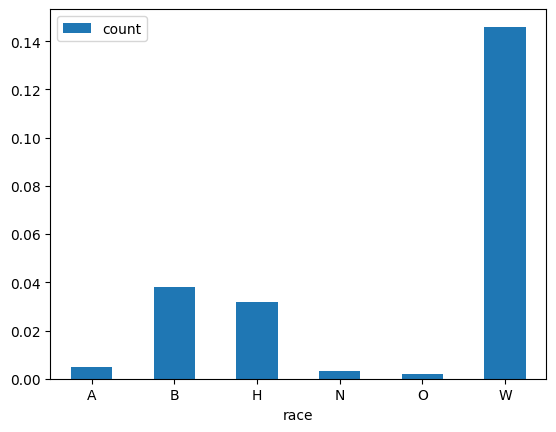

In [475]:
mental_illness_counter.plot.bar(x='race', y='count', rot=0)

**Dodaj kolumnę oznaczającą dzień tygodnia, w którym doszło do interwencji. Zlicz interwencje według odpowiedniego dnia tygodnia. Następnie stwórz wykres kolumnowy, tak aby dni tygodnia były uszeregowane od poniedziałku do niedzieli.**

In [440]:
df['Day'] = pd.to_datetime(df['date']).dt.day_name()
plot = df.pivot_table(values='name', index='Day', aggfunc='count')
plot=plot.reset_index()

def set_day_number(x):
  if x == 'Monday':
    return '1'
  elif x == 'Tuesday':
    return '2'
  elif x == 'Wednesday':
    return '3'
  elif x == 'Thursday':
      return '4'
  elif x == 'Friday':
      return '5'
  elif x == 'Saturday':
      return '6'
  elif x == 'Sunday':
      return '7'

plot['Day_nr'] = plot['Day'].apply(lambda x: set_day_number(x))
plot=plot.sort_values(by='Day_nr')
plot

,Day,name,Day_nr
1,Monday,726,1
5,Tuesday,816,2
6,Wednesday,829,3
4,Thursday,810,4
0,Friday,761,5
2,Saturday,721,6
3,Sunday,753,7


<Axes: xlabel='Day'>

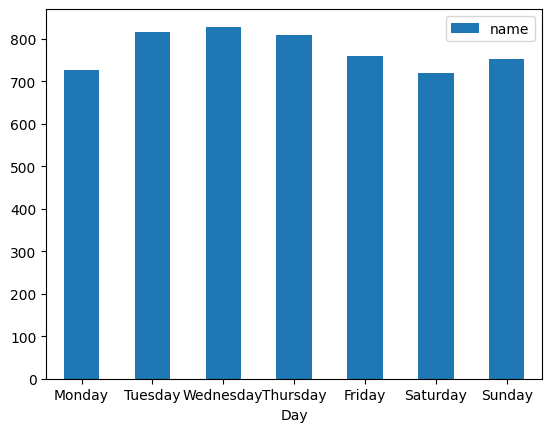

In [476]:
plot.plot.bar(x='Day', y='name', rot=0)

**Wczytaj do projektu dane dotyczące populacji w poszczególnych stanach USA oraz dane dotyczące skrótów poszczególnych stanów. Połącz te bazy danych w taki sposób, aby móc policzyć do ilu incydentów w bazie dotyczącej śmiertelnych interwencji doszło w przeliczeniu na 1000 mieszkańców każdego ze stanów.**

In [442]:
usa_states = pd.read_html('https://en.wikipedia.org/wiki/List_of_U.S._state_and_territory_abbreviations', header=0)[0]
usa_states=usa_states.iloc[:,[0,5]]
usa_states.rename(columns={usa_states.columns[0]:'State', usa_states.columns[1]:'Code'}, inplace=True)
usa_states.dropna(axis=0, inplace=True)

In [443]:
usa_population = pd.read_html('https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population', header=0)[0]
usa_population=usa_population[{'State', 'Census population, April 1, 2020 [1][2]'}]
usa_population.rename(columns={usa_population.columns[0]:'State', usa_population.columns[1]:'Population'}, inplace=True)

<ipython-input-443-67a57d94f793>:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  usa_population=usa_population[{'State', 'Census population, April 1, 2020 [1][2]'}]


In [444]:
state_population_and_symbol = pd.merge(usa_population,usa_states,how='inner',on='State')
state_population_and_symbol.set_index(['Code'], inplace=True)

In [445]:
def assign_state_symbol(x):
  return state_population_and_symbol.loc[x,'Population']

def bonus(row):
    return round((row['victim']/row['population'])*1000, 2)

count = df.pivot_table(values='name', index='state', aggfunc='count')
count.rename(columns={'name': 'victim'}, inplace=True)
count.reset_index(inplace=True)
count['population'] = count['state'].apply(lambda x: assign_state_symbol(x))
count['On 1000 case'] = count.apply(lambda row: bonus(row),axis=1)
count


,state,victim,population,On 1000 case
0,AK,39,733391,0.05
1,AL,104,5024279,0.02
2,AR,83,3011524,0.03
3,AZ,254,7151502,0.04
4,CA,799,39538223,0.02
5,CO,195,5773714,0.03
6,CT,21,3605944,0.01
7,DC,13,689545,0.02
8,DE,13,989948,0.01
9,FL,350,21538187,0.02
